# Task 1. Acquire the Data

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

#import warnings
#warnings.filterwarnings("error")


In [ ]:
!pip install keras

In [ ]:
# using keras to load the train and test data from Fashion-MNIST
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# check if they are of the correct shape, if not, AssertionError would be raised
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


4431872/4422102 [==============================] - 0s 0us/step


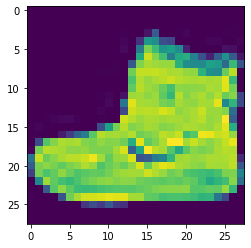

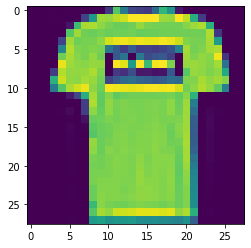

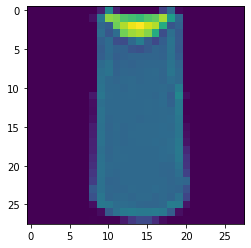

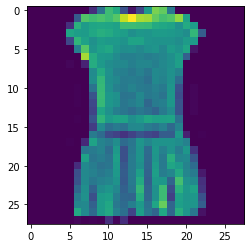

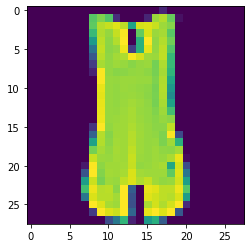

In [ ]:
# visualize the data
# we display the first 5 mages in the training set
for i in range(5):
  plt.figure()
  plt.imshow(x_train[i])


Data Preprocessing

In [ ]:
# vectorize data
# train 
print(f"x_train shape before vectorization: {x_train.shape}")
x_train = x_train.reshape(60000,784)
print(f"x_train shape after vectorization: {x_train.shape}\n")
print(f"y_train shape before vectorization: {y_train.shape}")
y_train = y_train.reshape(60000,1)
print(f"y_train shape after vectorization: {y_train.shape}\n")

# test
print(f"x_test shape before vectorization: {x_test.shape}")
x_test = x_test.reshape(10000,784)
print(f"x_test shape after vectorization: {x_test.shape}\n")
print(f"y_test shape before vectorization: {y_test.shape}")
y_test = y_test.reshape(10000,1)
print(f"y_test shape after vectorization: {y_test.shape}")

x_train shape before vectorization: (60000, 28, 28)
x_train shape after vectorization: (60000, 784)

y_train shape before vectorization: (60000,)
y_train shape after vectorization: (60000, 1)

x_test shape before vectorization: (10000, 28, 28)
x_test shape after vectorization: (10000, 784)

y_test shape before vectorization: (10000,)
y_test shape after vectorization: (10000, 1)


In [ ]:
classes, counts = np.unique(y_test, return_counts=True)
print(classes)

classes, counts = np.unique(y_train, return_counts=True)
print(classes)

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [ ]:
# data normalization 

# mean subtraction + standard deviation division 
x_train_zero_centred = x_train - np.mean(x_train, axis=0)
x_train_zero_centred = x_train_zero_centred / np.std(x_train, axis=0)
x_test_zero_centred = x_test - np.mean(x_test, axis=0)
x_test_zero_centred = x_test_zero_centred / np.std(x_test, axis=0)


# PCA
cov = np.dot(x_train_zero_centred.T, x_train_zero_centred) / x_train_zero_centred.shape[0]
U,S,V = np.linalg.svd(cov)
x_train_PCA = np.dot(x_train_zero_centred, U)
x_train_PCA_reduced = np.dot(x_train_zero_centred, U[:,:100]) # x_train_PCA becomes size [N x 100]
x_train_PCA_reduced_inverted = np.dot(x_train_PCA_reduced, U[:,:100].T)
# After the above, we would have reduced the original dataset of size [N x D] to one of size [N x 100], keeping the 100 dimensions of the data that contain the most variance.
cov_test = np.dot(x_test_zero_centred.T, x_test_zero_centred) / x_test_zero_centred.shape[0]
U_test,S_test,V_test = np.linalg.svd(cov_test)
x_test_PCA = np.dot(x_test_zero_centred, U_test)
x_test_PCA_reduced = np.dot(x_test_zero_centred, U[:,:100]) # x_train_PCA becomes size [N x 100]
# x_train_PCA_reduced_inverted = np.dot(x_train_PCA_reduced, U[:,:100].T)


# Whitening 
x_train_white = x_train_PCA / np.sqrt(S + 1e-5)
x_test_white = x_test_PCA / np.sqrt(S + 1e-5)

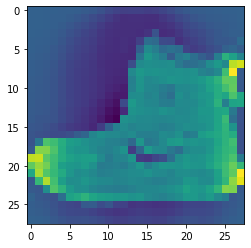

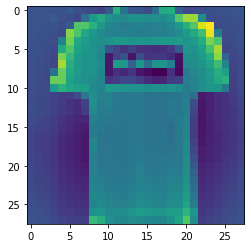

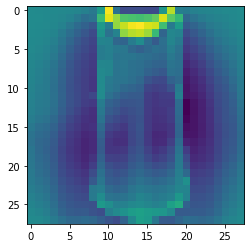

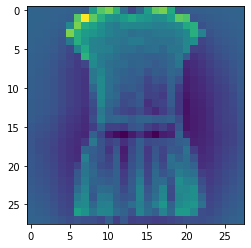

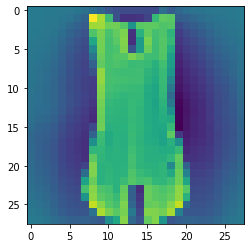

In [ ]:
# Visualize the transformations 

# After mean subtraction + standard deviation division 
for i in range(5):
  plt.figure()
  plt.imshow(x_train_zero_centred[i].reshape(28,28))

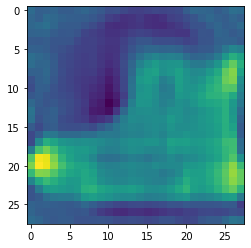

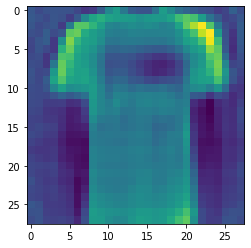

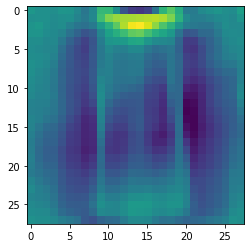

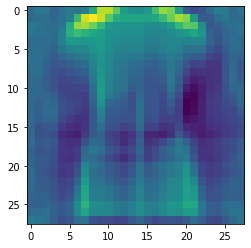

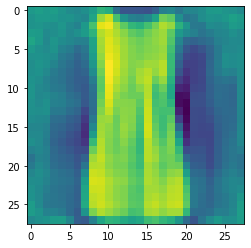

In [ ]:
# After PCA
for i in range(5):
  plt.figure()
  plt.imshow(x_train_PCA_reduced_inverted[i].reshape(28,28))

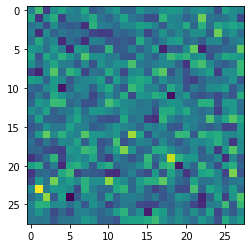

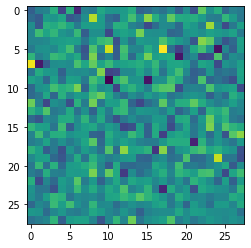

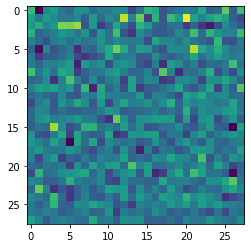

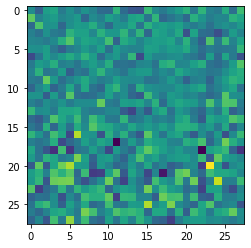

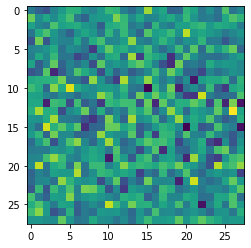

In [ ]:
# After whitening
for i in range(5):
  plt.figure()
  plt.imshow(x_train_white[i].reshape(28,28))

#Task 2

In [ ]:
# activation functions
logistic = lambda z: 1./ (1 + np.exp(-z))
dlogistic = lambda z: z*(1-z)
ReLu = lambda z: np.maximum(z,0)
dReLu = lambda z: (z>0)*1
# set gamma to 0.01
leakyReLu = lambda z: np.maximum(z,0) + 0.01*np.minimum(z,0)
dLeaky = lambda z: (z>0)*1+(z<0)*0.01
# parametric ReLu: make gamma a learnable parameter
#leakyReLu = lambda z, gamma: np.maximum(z,0) + gamma*np.minimum(z,0)
#dLeaky = lambda z, gamma: (z>0)*1+(z<0)*gamma
tanh = lambda z: (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
dtanh = lambda z: 1-tanh(z)**2

In [ ]:
class MLP:

    
    #M is the number of units in each hidden layers, actFunc is activation function, and numHidLayer is the number of hidden layers
    def __init__(self, actFunc = 'logistic', numHLayer = 1, M = [32], dropout=False): 
        self.M = M
        self.dropout = dropout
        self.numHLayer = numHLayer
        if(actFunc == 'logistic'):
          self.actFunc = logistic
          self.dActFunc = dlogistic
        elif (actFunc == 'relu'):
          self.actFunc = ReLu
          self.dActFunc = dReLu
        elif (actFunc == 'leakyRelu'):
          self.actFunc = leakyReLu
          self.dActFunc = dLeaky
        elif (actFunc == 'tanh'):
          self.actFunc = tanh
          self.dActFunc = dtanh
        
        if(numHLayer != len(M)):
          print("length of input hidden unit array does not match number of layers!")
          # print("im so tired lemma go sleep")
        
    
    def mini_train_plot(self, input, y, x_test, y_test, optimizer, epoch, batch_size=32):
      if_first_pass = True
      accuracies = np.zeros([2, epoch])
      for e in range(epoch):
        for batch in iterate_minibatches(input, y, batch_size, shuffle=True):
          x_batch, y_batch = batch
          self.fit(x_batch,y_batch,optimizer,first_pass=if_first_pass)
          if_first_pass = False
        yh_train = self.predict(input)
        train_acc = evaluate_acc(y, yh_train)
        accuracies[0,e] = train_acc
        yh_test = self.predict(x_test)
        test_acc = evaluate_acc(y_test, yh_test)
        accuracies[1,e] = test_acc
      return accuracies

    def mini_train(self, input, y, optimizer, epoch, batch_size=32):
      if_first_pass = True
      for e in range(epoch):
        for batch in iterate_minibatches(input, y, batch_size, shuffle=True):
          x_batch, y_batch = batch
          self.fit(x_batch,y_batch,optimizer,first_pass=if_first_pass)
          if_first_pass = False

    def fit(self, input, y, optimizer,first_pass=False):
        N,D = input.shape
        y = oneHotEncoding(y) #y is now of shape [n,c]
        C = y.shape[1]
            
        def gradient(input, y, params, biases):
            w = params
            bias = biases
            x = []
            x.append(input) 
            for i in range(self.numHLayer + 2):
              if (i == 0): #skips the first layer because first layer is the input layer (shape: NxD)
                '''
                if (self.dropout==True):
                  p = 0.8
                  mask = np.random.rand(N, D)
                  mask = (mask < p).astype(int)
                  x[0] = np.multiply(mask, x[0])
                  x[0] = x[0]/p
                else:
                  continue
                '''
                continue
              elif (i == self.numHLayer+1):
                z = softMax(np.dot(x[i-1], w[i-1])+bias[i-1].T)
                x.append(z)
              else:
                z = self.actFunc(np.dot(x[i-1], w[i-1])+bias[i-1].T)
                if (self.dropout==True):
                  p = 0.5
                  mask = np.random.rand(z.shape[0], z.shape[1])
                  mask = (mask < p).astype(int)
                  z = np.multiply(mask, z)
                  z = z/p
                x.append(z)

            #x should now be a tensor of length numHLayer+2 (i.e. x[numHLayer+1] == yh)
            dw = [] #dw should be a 3D tensor of length (numHLayer+1)
            dx = [] #dx should be a 3D tensor of length (numHLayer+1)
            dbias = []
            count = 0
            for i in reversed(range(1,self.numHLayer+2)):
              if (i == self.numHLayer + 1): #last layer
                dx.append(x[i] - y) #dy = yh - y #N
                dw.append(np.dot(x[i-1].T, dx[count])/N)
                dbias.append(np.sum(dx[count],axis=0, keepdims=True)/N)
              else:
                dx.append(np.dot(dx[count-1], w[i].T))
                dw.append(np.dot(x[i-1].T,dx[count]*self.dActFunc(x[i]))/N)
                dbias.append(np.sum(dx[count]*self.dActFunc(x[i]),axis=0, keepdims=True)/N)
              count = count +1
            dw = list(reversed(dw)) #now in normal order
            dbias = list(reversed(dbias))
            return dw,dbias
        if(first_pass):            
          w = []
          bias = []
          if (self.numHLayer != 0):
            first = np.append([D], self.M) #sleep is something we dont care abt. for each weight layer Wi = size A x B, sleep[i] == A
            second = np.append(self.M,[10])
            for i in range(self.numHLayer + 1):
              pain = np.random.randn(first[i],second[i]) * .01 #pain is temporary #(so they said) 
              w.append(pain)
              b = np.zeros((second[i],1))
              bias.append(b)
          else:
            pain = np.random.randn(D,10)* .01
            w.append(pain)
            b = np.zeros((10,1))
            bias.append(b)
          self.params = w
          self.biases = bias
        self.params, self.biases = optimizer.run(gradient, input, y, self.params,self.biases)
        return self
    
    def predict(self, input):
        w = self.params
        bias = self.biases
        x = []
        x.append(input) #x is a 3D tensor (matrix?) that records the units in each layer. 
        for i in range(self.numHLayer + 2):
          if (i == 0): #skips the first layer because first layer is the input layer (shape: NxD)
            continue
          elif (i == self.numHLayer+1):
            z = softMax(np.dot(x[i-1], w[i-1])+bias[i-1].T)
            x.append(z)
          else:
            z = self.actFunc(np.dot(x[i-1], w[i-1])+bias[i-1].T)
            x.append(z)
          '''
          else:
            z = self.actFunc(np.dot(x[i-1], w[i-1])) #N x M(i-1)
            x.append(z) #
        x[self.numHLayer + 1] = softMax(x[self.numHLayer + 1]) #softmax shape [N,c]
        '''
        x[self.numHLayer + 1] = np.argmax(x[self.numHLayer + 1], axis=1) #argmax shape[N]
        # x[self.numHLayer + 1] = oneHotEncoding(x[self.numHLayer + 1]) #shape[N,c]
        # x[self.numHLayer + 1] = x[self.numHLayer + 1].flatten()
        x[self.numHLayer + 1] = x[self.numHLayer + 1].astype(int)
        return x[self.numHLayer + 1]
    

evaluation function

In [ ]:
# evaluate_acc takes in true labels and target labels and output accuracy score
def evaluate_acc(y_true, y_pred):
    accuracy = np.sum(y_pred == y_true, dtype=int)/y_pred.shape[0]
    #print(f"model accuracy: {accuracy}")
    return accuracy

In [ ]:
def softMax(A): #softmax
    """
    Computes a softmax function. 
    Input: A (N, c) ndarray.
    Returns: (N,c) ndarray.
    """
    Amax = np.max(A,axis=1)[:,None]
    exp = np.exp(A - Amax)
    sum_exp = np.sum(exp, axis=1, keepdims=True)
    A = exp/sum_exp
    return A

In [ ]:
def oneHotEncoding(a):
  '''
  takes in [N] ndarray
  returns [N,c] one hot encoded ndarray
  '''
  b = np.zeros((a.size, 10))
  b[np.arange(a.size),a] = 1
  b = b.astype(int)
  return b

In [ ]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params, biases):
        #norms = np.array([np.inf])
        #t = 1
        grad, grad_bias = gradient_fn(x, y, params,biases)
        for p in range(len(params)):
            #params[len(params)-1] = params[len(params)-1].flatten()
            params[p] -= self.learning_rate * grad[p]
            biases[p] -= self.learning_rate * grad_bias[p].T
        '''
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad, grad_bias = gradient_fn(x, y, params,biases)
            for p in range(len(params)):
                #params[len(params)-1] = params[len(params)-1].flatten()
                params[p] -= self.learning_rate * grad[p]
                biases[p] -= self.learning_rate * grad_bias[p].T
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        '''
        return params, biases

In [ ]:
def iterate_minibatches(x, label, batchsize, shuffle=True):
  #iterates through the minibatches, each batch has a batch size of batchsize
    assert x.shape[0] == label.shape[0]
    if shuffle:
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
    for start in range(0, x.shape[0], batchsize):
        end = min(start + batchsize, x.shape[0])
        if shuffle:
            seg = indices[start:end]
        else:
            seg = slice(start,end)
        yield x[seg], label[seg]

#Task 3

In [ ]:
y_test = y_test.flatten()
y_train = y_train.flatten()

### Question 1

#### zero hidden layer

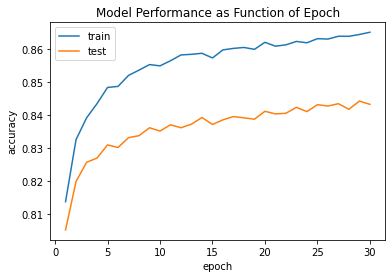

In [ ]:
# plot
model0 = MLP(numHLayer=0, M=[])
optimizer = GradientDescent(learning_rate=.1, max_iters=50)
epochs = 30

x = list(range(1, epochs+1))

accuracies = model0.mini_train_plot(x_train_zero_centred, y_train, x_test_zero_centred, y_test, optimizer, epoch=epochs, batch_size=2000)
y = accuracies[0,:].tolist() # train
y2 = accuracies[1,:].tolist() # test

fig, ax = plt.subplots()

ax.plot(x, y, label="train")
ax.plot(x, y2, label="test")
ax.legend()
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.set_title('Model Performance as Function of Epoch')
plt.show()

choosing learning rate

In [ ]:
model0 = MLP(numHLayer=0, M=[])
optimizer = GradientDescent(learning_rate=.001, max_iters=50)
model0.mini_train(x_train_zero_centred, y_train, optimizer, epoch=3, batch_size=2000)
yh = model0.predict(x_test_zero_centred)
evaluate_acc(y_test, yh)

0.6588

In [ ]:
model0 = MLP(numHLayer=0, M=[])
optimizer = GradientDescent(learning_rate=.01, max_iters=50)
model0.mini_train(x_train_zero_centred, y_train, optimizer, epoch=3, batch_size=2000)
yh = model0.predict(x_test_zero_centred)
evaluate_acc(y_test, yh)

0.7664

In [ ]:
model0 = MLP(numHLayer=0, M=[])
optimizer = GradientDescent(learning_rate=.1, max_iters=50)
model0.mini_train(x_train_zero_centred, y_train, optimizer, epoch=3, batch_size=2000)
yh = model0.predict(x_test_zero_centred)
evaluate_acc(y_test, yh)

0.8271

#### 1 hidden layer + ReLu

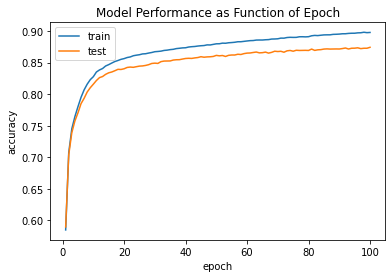

In [ ]:
# plot
model1 = MLP(actFunc='relu', numHLayer=1, M=[128])
optimizer = GradientDescent(learning_rate=.05)
epochs = 100

x = list(range(1, epochs+1))

accuracies = model1.mini_train_plot(x_train_zero_centred, y_train, x_test_zero_centred, y_test, optimizer, epoch=epochs, batch_size=2000)
y = accuracies[0,:].tolist() # train
y2 = accuracies[1,:].tolist() # test

fig, ax = plt.subplots()

ax.plot(x, y, label="train")
ax.plot(x, y2, label="test")
ax.legend()
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.set_title('Model Performance as Function of Epoch')
plt.show()

choose learning rate

In [ ]:
# one hidden layer with 128 units + ReLu
model1 = MLP(actFunc='relu', numHLayer=1, M=[128])
optimizer = GradientDescent(learning_rate=.001, max_iters=50)
model1.mini_train(x_train_zero_centred, y_train, optimizer, epoch=10, batch_size=2000)
yh = model1.predict(x_test_zero_centred)
evaluate_acc(y_test, yh)

0.5914

In [ ]:
# one hidden layer with 128 units + ReLu
model1 = MLP(actFunc='relu', numHLayer=1, M=[128])
optimizer = GradientDescent(learning_rate=.01, max_iters=50)
model1.mini_train(x_train_zero_centred, y_train, optimizer, epoch=10, batch_size=2000)
yh = model1.predict(x_test_zero_centred)
evaluate_acc(y_test, yh)

0.7051

In [ ]:
# one hidden layer with 128 units + ReLu
model1 = MLP(actFunc='relu', numHLayer=1, M=[128])
optimizer = GradientDescent(learning_rate=.1, max_iters=50)
model1.mini_train(x_train_zero_centred, y_train, optimizer, epoch=10, batch_size=2000)
yh = model1.predict(x_test_zero_centred)
evaluate_acc(y_test, yh)

0.8421

#### 2 hidden layes + ReLu

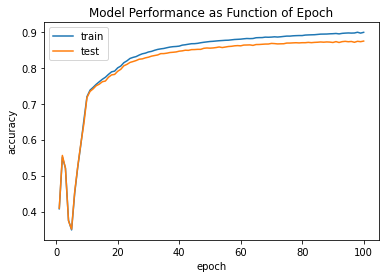

In [ ]:
# plot
model2 = MLP(actFunc='relu', numHLayer=2, M=[128, 128])
optimizer = GradientDescent(learning_rate=.05, max_iters=50)
epochs = 100

x = list(range(1, epochs+1))

accuracies = model2.mini_train_plot(x_train_zero_centred, y_train, x_test_zero_centred, y_test, optimizer, epoch=epochs, batch_size=2000)
y = accuracies[0,:].tolist() # train
y2 = accuracies[1,:].tolist() # test

fig, ax = plt.subplots()

ax.plot(x, y, label="train")
ax.plot(x, y2, label="test")
ax.legend()
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.set_title('Model Performance as Function of Epoch')
plt.show()

choose learning rate

In [ ]:
model2 = MLP(actFunc='relu', numHLayer=2, M=[128, 128])
optimizer = GradientDescent(learning_rate=.001, max_iters=50)
model2.mini_train(x_train_zero_centred, y_train, optimizer, epoch=20, batch_size=2000)
yh = model2.predict(x_test_zero_centred)
evaluate_acc(y_test, yh) 

0.2298

In [ ]:
model2 = MLP(actFunc='relu', numHLayer=2, M=[128, 128])
optimizer = GradientDescent(learning_rate=.01, max_iters=50)
model2.mini_train(x_train_zero_centred, y_train, optimizer, epoch=20, batch_size=2000)
yh = model2.predict(x_test_zero_centred)
evaluate_acc(y_test, yh) 

0.3435

In [ ]:
model2 = MLP(actFunc='relu', numHLayer=2, M=[128, 128])
optimizer = GradientDescent(learning_rate=.1, max_iters=50)
model2.mini_train(x_train_zero_centred, y_train, optimizer, epoch=20, batch_size=2000)
yh = model2.predict(x_test_zero_centred)
evaluate_acc(y_test, yh) 

0.8408

### Question 2

#### leaky Relu

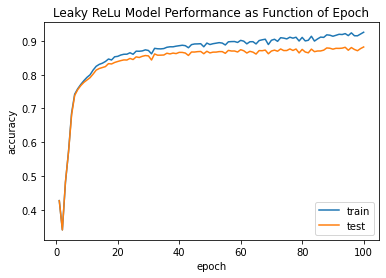

In [ ]:
# plot
model_leaky = MLP(actFunc='leakyRelu', numHLayer=2, M=[128, 128])
optimizer = GradientDescent(learning_rate=.1, max_iters=50)
epochs = 100

x = list(range(1, epochs+1))

accuracies = model_leaky.mini_train_plot(x_train_zero_centred, y_train, x_test_zero_centred, y_test, optimizer, epoch=epochs, batch_size=2000)
y = accuracies[0,:].tolist() # train
y2 = accuracies[1,:].tolist() # test

fig, ax = plt.subplots()

ax.plot(x, y, label="train")
ax.plot(x, y2, label="test")
ax.legend()
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.set_title('Leaky ReLu Model Performance as Function of Epoch')
plt.show()

In [ ]:
# two hidden layers with 128 units each + Leaky ReLu
model_leaky = MLP(actFunc='leakyRelu', numHLayer=2, M=[128, 128])
optimizer = GradientDescent(learning_rate=.1)
model_leaky.mini_train(x_train_zero_centred, y_train, optimizer, epoch=20, batch_size=2000)
yh = model_leaky.predict(x_test_zero_centred)
evaluate_acc(y_test, yh)

0.8424

#### tanh

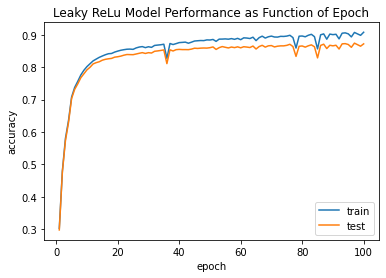

In [ ]:
# plot
model_tanh = MLP(actFunc='tanh', numHLayer=2, M=[128, 128])
optimizer = GradientDescent(learning_rate=.1, max_iters=50)
epochs = 100

x = list(range(1, epochs+1))

accuracies = model_tanh.mini_train_plot(x_train_zero_centred, y_train, x_test_zero_centred, y_test, optimizer, epoch=epochs, batch_size=2000)
y = accuracies[0,:].tolist() # train
y2 = accuracies[1,:].tolist() # test

fig, ax = plt.subplots()

ax.plot(x, y, label="train")
ax.plot(x, y2, label="test")
ax.legend()
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.set_title('Leaky ReLu Model Performance as Function of Epoch')
plt.show()

In [ ]:
# two hidden layers with 128 units each + tanh
model_tanh = MLP(actFunc='tanh', numHLayer=2, M=[128, 128])
optimizer = GradientDescent(learning_rate=.1)
model_tanh.mini_train(x_train_zero_centred, y_train, optimizer, epoch=20, batch_size=2000)
yh = model_tanh.predict(x_test_zero_centred)
evaluate_acc(y_test, yh)

0.8324

### Question 3: dropout regularization

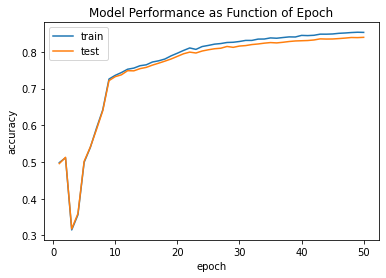

In [ ]:
# plot
model_dropout = MLP(actFunc='relu', numHLayer=2, M=[128, 128], dropout=True)
optimizer = GradientDescent(learning_rate=.1, max_iters=10)
epochs = 50

x = list(range(1, epochs+1))

accuracies = model_dropout.mini_train_plot(x_train_zero_centred, y_train, x_test_zero_centred, y_test, optimizer, epoch=epochs, batch_size=2000)
y = accuracies[0,:].tolist() # train
y2 = accuracies[1,:].tolist() # test

fig, ax = plt.subplots()

ax.plot(x, y, label="train")
ax.plot(x, y2, label="test")
ax.legend()
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.set_title('Model Performance as Function of Epoch')
plt.show()

In [ ]:
model_dropout = MLP(actFunc='relu', numHLayer=2, M=[128, 128], dropout=True)
optimizer = GradientDescent(learning_rate=.1, max_iters=50)
model_dropout.mini_train(x_train_zero_centred, y_train, optimizer, epoch=200, batch_size=2000)
yh = model_dropout.predict(x_test_zero_centred)
evaluate_acc(y_test, yh)

0.8683

### Question 4: unnormalized images

In [ ]:
model_unnormalized = MLP(actFunc='relu', numHLayer=2, M=[128, 128])
optimizer = GradientDescent(learning_rate=.1, max_iters=50)
model_unnormalized.mini_train(x_train, y_train, optimizer, epoch=10, batch_size=2000)
yh = model_unnormalized.predict(x_test)
evaluate_acc(y_test, yh) 

0.1

### Question 5: CNN with pytorch

In [ ]:
# CNN model with pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

import math

train_dataset = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_dataset = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class CNN(nn.Module):
    def __init__(self, c1, c2, input_channel=1, full_layer_size=128, num_classes=10, k=3):
        super(CNN, self).__init__()
        self.c2 = c2
        self.conv_layer1 = nn.Conv2d(input_channel, c1, k)
        self.conv_layer2 = nn.Conv2d(c1, c2, k)
        self.pool = nn.MaxPool2d(kernel_size=2) # reduce dimension of output by 1/2
        self.dim = math.floor((math.floor((28-k+1)/2)-k+1)/2) # calculate new dimension
        self.full_layer1 = nn.Linear(self.dim*self.dim*self.c2, full_layer_size)
        self.full_layer2 = nn.Linear(full_layer_size, full_layer_size)
        self.output_layer = nn.Linear(full_layer_size, num_classes)
        
    def forward(self, x):
        out = self.pool(F.relu(self.conv_layer1(x)))
        out = self.pool(F.relu(self.conv_layer2(out)))
        out = out.view(-1, self.dim*self.dim*self.c2) # flatten
        out = F.relu(self.full_layer1(out))
        out = F.relu(self.full_layer2(out))
        out = self.output_layer(out)
        return out


#### hyperparameter tuning
kernel_size, out_channel, (stride, padding)

##### kernal dimension = 3*3

In [ ]:
# default kernel size (3)
model = CNN(c1=16, c2=32)

# If GPU is available, move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
loss_func = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

losses = []
for epoch in range(5):
    epoch_loss = []

    # Iterate over data
    for batch_idx, (images, labels) in enumerate(train_loader):  
      #move tensor to the same device (CPU/GPU) as the model
      images, labels = images.to(device), labels.to(device)
      
      # Zero the parameter gradients
      optimizer.zero_grad()  
      
      # forward + loss calc + backward + step
      outputs = model(images)
      loss = loss_func(outputs, labels)
      loss.backward()
      optimizer.step()

      if batch_idx % 500 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

      epoch_loss.append(loss.item())
    losses.append(np.mean(epoch_loss))


Epoch: 1, Loss: 0.8066
Epoch: 1, Loss: 0.7650
Epoch: 2, Loss: 0.6875
Epoch: 2, Loss: 0.5898
Epoch: 3, Loss: 0.6339
Epoch: 3, Loss: 0.5931
Epoch: 4, Loss: 0.5020
Epoch: 4, Loss: 0.6667
Epoch: 5, Loss: 0.3989
Epoch: 5, Loss: 0.5645


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {(100 * correct / total)} %%")

Test Accuracy: 78.87 %%


##### kernel dimension = 5*5

In [ ]:
model_k5 = CNN(c1=16, c2=32, k=5)

# If GPU is available, move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_k5.to(device)

CNN(
  (conv_layer1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv_layer2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (full_layer1): Linear(in_features=512, out_features=128, bias=True)
  (full_layer2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
loss_func = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model_k5.parameters(), lr=1e-3, momentum=0.9)

losses = []
for epoch in range(5):
    epoch_loss = []

    # Iterate over data
    for batch_idx, (images, labels) in enumerate(train_loader):  
      #move tensor to the same device (CPU/GPU) as the model
      images, labels = images.to(device), labels.to(device)
      
      # Zero the parameter gradients
      optimizer.zero_grad()  
      
      # forward + loss calc + backward + step
      outputs = model_k5(images)
      loss = loss_func(outputs, labels)
      loss.backward()
      optimizer.step()

      if batch_idx % 500 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

      epoch_loss.append(loss.item())
    losses.append(np.mean(epoch_loss))


Epoch: 1, Loss: 2.3019
Epoch: 1, Loss: 2.2803
Epoch: 2, Loss: 2.2660
Epoch: 2, Loss: 1.0261
Epoch: 3, Loss: 0.9560
Epoch: 3, Loss: 0.9258
Epoch: 4, Loss: 0.6510
Epoch: 4, Loss: 0.7983
Epoch: 5, Loss: 0.6734
Epoch: 5, Loss: 0.7447


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_k5(images)
        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {(100 * correct / total)} %%")

Test Accuracy: 75.02 %%


##### kernel dimension = 2*2

In [ ]:
# kernel size = 2
model_k2 = CNN(c1=16, c2=32, k=2)

# If GPU is available, move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_k2.to(device)

CNN(
  (conv_layer1): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1))
  (conv_layer2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (full_layer1): Linear(in_features=1152, out_features=128, bias=True)
  (full_layer2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
loss_func = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model_k2.parameters(), lr=1e-3, momentum=0.9)

losses = []
for epoch in range(5):
    epoch_loss = []

    # Iterate over data
    for batch_idx, (images, labels) in enumerate(train_loader):  
      #move tensor to the same device (CPU/GPU) as the model
      images, labels = images.to(device), labels.to(device)
      
      # Zero the parameter gradients
      optimizer.zero_grad()  
      
      # forward + loss calc + backward + step
      outputs = model_k2(images)
      loss = loss_func(outputs, labels)
      loss.backward()
      optimizer.step()

      if batch_idx % 500 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

      epoch_loss.append(loss.item())
    losses.append(np.mean(epoch_loss))

Epoch: 1, Loss: 2.3099
Epoch: 1, Loss: 2.2664
Epoch: 2, Loss: 2.2458
Epoch: 2, Loss: 1.2034
Epoch: 3, Loss: 0.8960
Epoch: 3, Loss: 0.7210
Epoch: 4, Loss: 0.6802
Epoch: 4, Loss: 0.6441
Epoch: 5, Loss: 0.6208
Epoch: 5, Loss: 0.5640


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_k2(images)
        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {(100 * correct / total)} %%")

Test Accuracy: 76.48 %%


##### kernel size = 3*3, first output channel size = 32, second output chnnel size = 64

In [ ]:
# default kernel size (3)
model = CNN(c1=32, c2=64)

# If GPU is available, move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv_layer1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (full_layer1): Linear(in_features=1600, out_features=128, bias=True)
  (full_layer2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
loss_func = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

losses = []
for epoch in range(5):
    epoch_loss = []

    # Iterate over data
    for batch_idx, (images, labels) in enumerate(train_loader):  
      #move tensor to the same device (CPU/GPU) as the model
      images, labels = images.to(device), labels.to(device)
      
      # Zero the parameter gradients
      optimizer.zero_grad()  
      
      # forward + loss calc + backward + step
      outputs = model(images)
      loss = loss_func(outputs, labels)
      loss.backward()
      optimizer.step()

      if batch_idx % 500 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

      epoch_loss.append(loss.item())
    losses.append(np.mean(epoch_loss))


Epoch: 1, Loss: 2.3057
Epoch: 1, Loss: 1.1546
Epoch: 2, Loss: 1.0527
Epoch: 2, Loss: 0.7910
Epoch: 3, Loss: 0.9383
Epoch: 3, Loss: 0.7108
Epoch: 4, Loss: 0.7136
Epoch: 4, Loss: 0.7302
Epoch: 5, Loss: 0.9032
Epoch: 5, Loss: 0.6492


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {(100 * correct / total)} %%")

Test Accuracy: 75.28 %%


#### final model: k=3, c1=16, c2=32
trained with more epochs

In [ ]:
model = CNN(c1=16, c2=32)

# If GPU is available, move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv_layer1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (full_layer1): Linear(in_features=800, out_features=128, bias=True)
  (full_layer2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
loss_func = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

losses = []
for epoch in range(30):
    epoch_loss = []

    # Iterate over data
    for batch_idx, (images, labels) in enumerate(train_loader):  
      #move tensor to the same device (CPU/GPU) as the model
      images, labels = images.to(device), labels.to(device)
      
      # Zero the parameter gradients
      optimizer.zero_grad()  
      
      # forward + loss calc + backward + step
      outputs = model(images)
      loss = loss_func(outputs, labels)
      loss.backward()
      optimizer.step()

      if batch_idx % 500 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

      epoch_loss.append(loss.item())
    losses.append(np.mean(epoch_loss))


Epoch: 1, Loss: 2.2994
Epoch: 1, Loss: 1.5105
Epoch: 2, Loss: 1.0035
Epoch: 2, Loss: 0.7402
Epoch: 3, Loss: 0.7996
Epoch: 3, Loss: 0.6796
Epoch: 4, Loss: 0.6392
Epoch: 4, Loss: 0.7595
Epoch: 5, Loss: 0.5221
Epoch: 5, Loss: 0.5559
Epoch: 6, Loss: 0.6046
Epoch: 6, Loss: 0.6544
Epoch: 7, Loss: 0.5378
Epoch: 7, Loss: 0.4796
Epoch: 8, Loss: 0.6640
Epoch: 8, Loss: 0.3995
Epoch: 9, Loss: 0.3938
Epoch: 9, Loss: 0.5254
Epoch: 10, Loss: 0.3543
Epoch: 10, Loss: 0.4720
Epoch: 11, Loss: 0.4560
Epoch: 11, Loss: 0.4496
Epoch: 12, Loss: 0.4857
Epoch: 12, Loss: 0.4600
Epoch: 13, Loss: 0.3056
Epoch: 13, Loss: 0.5286
Epoch: 14, Loss: 0.3794
Epoch: 14, Loss: 0.2774
Epoch: 15, Loss: 0.4666
Epoch: 15, Loss: 0.3763
Epoch: 16, Loss: 0.4200
Epoch: 16, Loss: 0.3577
Epoch: 17, Loss: 0.3824
Epoch: 17, Loss: 0.3483
Epoch: 18, Loss: 0.4331
Epoch: 18, Loss: 0.3391
Epoch: 19, Loss: 0.2397
Epoch: 19, Loss: 0.3441
Epoch: 20, Loss: 0.3426
Epoch: 20, Loss: 0.5181
Epoch: 21, Loss: 0.4046
Epoch: 21, Loss: 0.3849
Epoch: 22,

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {(100 * correct / total)} %%")

Test Accuracy: 87.03 %%


###Question 6

try other normalization methods

ReLu, 1 hidden layer, PCA

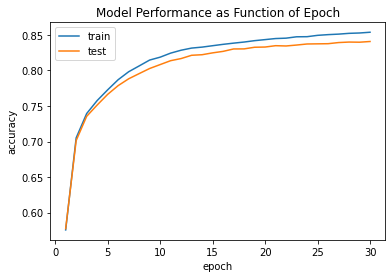

In [ ]:
# plot
model = MLP(actFunc='relu', numHLayer=1, M=[128])
optimizer = GradientDescent(learning_rate=.05, max_iters=50)
epochs = 30

x = list(range(1, epochs+1))

accuracies = model.mini_train_plot(x_train_PCA_reduced, y_train, x_test_PCA_reduced, y_test, optimizer, epoch=epochs, batch_size=2000)
y = accuracies[0,:].tolist() # train
y2 = accuracies[1,:].tolist() # test

fig, ax = plt.subplots()

ax.plot(x, y, label="train")
ax.plot(x, y2, label="test")
ax.legend()
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.set_title('Model Performance as Function of Epoch')
plt.show()

In [ ]:
model = MLP(actFunc='relu', numHLayer=1, M=[128])
optimizer = GradientDescent(learning_rate=.1, max_iters=50)
model.mini_train(x_train_PCA_reduced, y_train, optimizer, epoch=3, batch_size=2000)
yh = model.predict(x_test_PCA_reduced)
evaluate_acc(y_test, yh)

0.7782

ReLu, 1 hidden layer, whitening

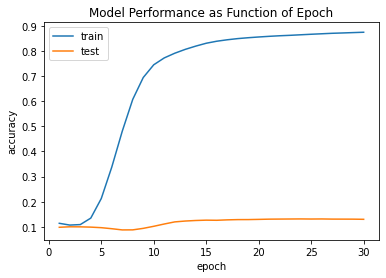

In [ ]:
# plot
model = MLP(actFunc='relu', numHLayer=1, M=[128])
optimizer = GradientDescent(learning_rate=.05, max_iters=50)
epochs = 30

x = list(range(1, epochs+1))

accuracies = model.mini_train_plot(x_train_white, y_train, x_test_white, y_test, optimizer, epoch=epochs, batch_size=2000)
y = accuracies[0,:].tolist() # train
y2 = accuracies[1,:].tolist() # test

fig, ax = plt.subplots()

ax.plot(x, y, label="train")
ax.plot(x, y2, label="test")
ax.legend()
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.set_title('Model Performance as Function of Epoch')
plt.show()

try different numbers of hidden units (with more epochs and smaller batch size)

In [ ]:
for i in range(4):
  model1 = MLP(actFunc='relu', numHLayer=1, M=[(i+1)*64])
  optimizer = GradientDescent(learning_rate=.1, max_iters=50)
  model1.mini_train(x_train_zero_centred, y_train, optimizer, epoch=200, batch_size=400)
  yh = model1.predict(x_test_zero_centred)
  print("%d hidden units: accuracy = %f" %((i+1)*64, evaluate_acc(y_test, yh)))

64 hidden units: accuracy = 0.863800
128 hidden units: accuracy = 0.886100
192 hidden units: accuracy = 0.890000
256 hidden units: accuracy = 0.890600
